# Gridworld with First Visit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# display output
from random import uniform
import random
import time
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## First-visit MC Control 

In [4]:
# create a grid object
grid = Gridworld(5)

In [5]:
# Initiate a random policy
random_policy = np.random.randint(1000, size=(state_count, action_count))
random_policy = random_policy/random_policy.sum(axis=1)[:,None]
policy = random_policy

In [6]:
# random policy
policy

array([[0.23282828, 0.27777778, 0.0510101 , 0.43838384],
       [0.2147342 , 0.13813311, 0.29468397, 0.35244872],
       [0.        , 0.43147208, 0.21675127, 0.35177665],
       [0.41307578, 0.00965825, 0.5564636 , 0.02080238],
       [0.00514328, 0.57237325, 0.07788391, 0.34459956],
       [0.17760181, 0.36840121, 0.21794872, 0.23604827],
       [0.44400199, 0.20557491, 0.25584868, 0.09457442],
       [0.46831825, 0.33539781, 0.11719867, 0.07908528],
       [0.34850455, 0.26701344, 0.19679237, 0.18768964],
       [0.41192535, 0.39736004, 0.1142467 , 0.07646791],
       [0.27444988, 0.22066015, 0.20293399, 0.30195599],
       [0.3317942 , 0.35224274, 0.30474934, 0.01121372],
       [0.09001458, 0.3483965 , 0.22631195, 0.33527697],
       [0.05644715, 0.37963475, 0.43054787, 0.13337023],
       [0.01375059, 0.38454244, 0.36225699, 0.23944998],
       [0.14192056, 0.20246818, 0.35364443, 0.30196683],
       [0.02035021, 0.384761  , 0.33601514, 0.25887364],
       [0.24061962, 0.22994836,

### Create an Episode following Policy

In [7]:
def generate_episode(steps):

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector)

        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
        
    return state_list, action_list, reward_list

### First Visit MC

In [8]:
# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

In [9]:
# intialize parameters
gamma = 0.99
epsilon = 0.1

In [10]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

In [11]:
# iterate 500 times: each time, generating an episode of 200 steps
max_steps = 200

# define variables for keeping track of time steps
Terminal = max_steps
t_list=[]
for i in range(1,max_steps+1):
    t = Terminal - i
    t_list.append(t)

In [12]:
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []

# iteration 500 times
for iteration in range(500):
  
    # generate an episode of specified step count
    state_list, action_list, reward_list = generate_episode(max_steps)
    
    # calculate average reward of each episode
    average_reward_list.append(Average(reward_list))
    
    # obtain cumulative reward for plotting
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)

    # intialize variables
    G = 0
    delta = 0
    
    # initiate returns and visited list to none
    returns_list = []
    visited_list = []

    # loop for each step of episode: T-1, T-2, T-3 ... 0 = 199, 198, 197 ... 0
    for t in t_list:

        # calculate G: starting with the last reward at index t (naturally accounts for pseudocode's "t-1")
        G = gamma*G + reward_list[t]
        
        # combine state action pair, for example, state = [0,0], action = [0,1], state_action_pair = [0,0,0,1]
        state_action_pair = []
        state_action_pair.extend(state_list[t])
        state_action_pair.extend(action_list[t])

        # check if state action pair have been visited before (if not: continue, else: move to the next time step)
        if state_action_pair not in visited_list:

            # add state action pair to visited list
            visited_list.append(state_action_pair)

            # append G to returns
            returns_list.append(G)

            # find state and action index, for example, converting action [-1, 0] to 0, and same for state #
            state_index = grid.states.index(state_list[t])
            action_index = actions.index(action_list[t])

            # calculate max delta change for plotting max q value change
            delta = max(delta, np.abs(Average(returns_list) - Q_values[state_index][action_index]))      
            
            # write Q_values to the state-action pair
            Q_values[state_index][action_index] = Average(returns_list)

            # choose best action at given state
            choose_action = np.argmax(Q_values[state_index])

            # overwrite policy
            for a in range(action_count): # for action in actions [0, 1, 2, 3]
                if choose_action == a: # if the choose_action is the same as the current action
                    policy[state_index][a] = 1 - epsilon + epsilon/action_count 
                else: # if choose_action is not the same as the current action
                    policy[state_index][a] = epsilon/action_count
    
    # append delta to list
    delta_list.append(delta)

Text(0, 0.5, 'Max Delta')

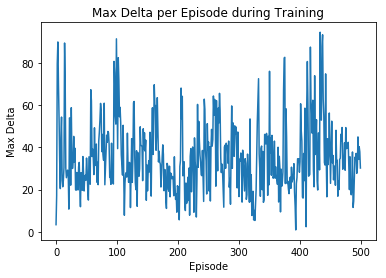

In [13]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

Text(0, 0.5, 'Average Reward')

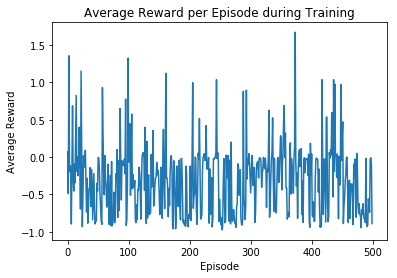

In [14]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

Text(0, 0.5, 'Cumulative Reward')

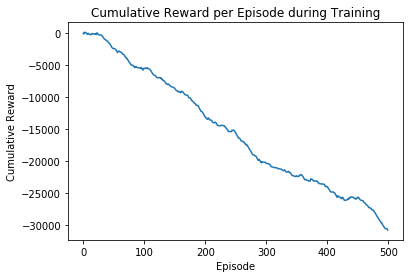

In [15]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [16]:
# total unique state action pairs at the end of one episode
print(len(visited_list))

13


In [17]:
np.set_printoptions(precision=2)
Q_values

array([[ -1.  , -21.86,  -8.95, -14.94],
       [-18.81, -19.67,   2.  , -46.01],
       [  4.1 , -20.83, -12.29,   3.32],
       [-43.71, -48.6 , -24.6 , -21.57],
       [-15.39, -15.25, -16.02, -24.02],
       [ -7.  ,  -2.39, -33.37,  -1.  ],
       [-46.9 ,  -0.73,  -8.33,  -3.73],
       [  1.37, -44.13, -28.72, -47.61],
       [-48.57, -20.27, -23.8 , -48.16],
       [-26.15, -28.07, -31.31, -21.53],
       [ -4.69,   0.  ,  -8.38,  -0.2 ],
       [-45.76,  -7.9 ,  -0.3 ,   0.  ],
       [-44.91, -47.09,  -7.55, -46.06],
       [-17.79, -17.01, -38.7 , -18.72],
       [-29.79, -17.62, -25.64, -43.72],
       [-29.89,  -5.47, -25.88,  -8.15],
       [  0.  ,   0.  ,   0.  ,  -6.12],
       [-38.51, -34.69,  -7.14, -10.6 ],
       [-41.48, -35.87, -35.3 , -31.19],
       [-32.64, -26.78, -32.44, -44.11],
       [  0.  , -21.45, -22.96, -28.8 ],
       [  0.  ,   0.  ,  -0.21,   0.  ],
       [ -0.47, -21.46, -23.08,  -6.67],
       [-38.61, -16.29, -19.21, -24.48],
       [-41.66, 

In [18]:
policy

array([[0.93, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.93, 0.03, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.93, 0.03, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03]])

## Testing

In [19]:
avg_test_reward_list = []

# using the trained policy, generate 20 episodes
for test in range(20):
    
    # generate an episode of specified step count
    state_list, action_list, reward_list = generate_episode(max_steps)
    
    avg_test_reward_list.append(Average(reward_list))

Text(0, 0.5, 'Average Reward')

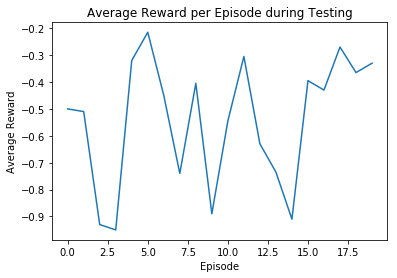

In [20]:
# average reward per episode
plt.plot(avg_test_reward_list)
plt.title('Average Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

## Visualize 

In [21]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(policy)):
    
    # find the best action at each state
    best_action = np.argmax(policy[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
       0      1     2      3      4
0     up   down    up   left  right
1   left  right    up  right   left
2  right   left  down  right  right
3  right     up  down   left  right
4     up     up    up  right   down

